In [35]:
import sys
import os

# Add the parent directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [36]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u

from cherenkov_sim.particle import Particle
from cherenkov_sim.muon import Muon
from cherenkov_sim.gamma import Gamma
from cherenkov_sim.material import Material
from cherenkov_sim.tracker import ParticleTracker, GammaTracker
from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK

import numpy as np
from astropy import units as u

ice = Material(
    name = 'Ice',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 0.9180 * u.g / u.cm**3,
    I = 79.7 * u.eV, 
    n = 1.309,
    X0 = 39.31 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

water = Material(
    name = 'water',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 1 * u.g / u.cm**3,
    I = 79.7 * u.eV,
    n = 1.333,
    X0 = 36.08 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

In [37]:
# Extract starting position randomly from a circle corresponding to the top of the tank
N_event = 1 # Choose number of particles 

# Gen. surface radius 
R_gen = 180 * u.cm 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = 140 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0   


def rnd_direction(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)

    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    cos_theta_squared = np.random.uniform(np.cos(theta_1.to(u.rad))**2,np.cos(theta_0.to(u.rad))**2, size=N_event)
    cos_theta = np.sqrt(cos_theta_squared)
    theta = np.arccos(cos_theta) 
    return theta * u.rad, phi * u.rad

In [38]:
# Track muons inside the tank, considering energy loss and Cherenkov produciton 

muon_theta, muon_phi = rnd_direction(N_event)
x0,y0,z0 = rnd_tank_start(R_gen, N_event)  

initial_position = np.array([x0[0].value,y0[0].value,z0[0].value]) * u.cm
theta = muon_theta[0]
phi = muon_phi[0]

In [39]:
e = 0.01 * u.GeV
gamma = Gamma(energy = e)

# Create the Tracker
gamma_tracker = GammaTracker(gamma, ice, step_size= - 1.0 * u.cm,
                      position=initial_position, 
                      zenith=muon_theta[0], 
                      azimuth=muon_phi[0],
                      is_verbose = True)


In [40]:
out = gamma_tracker.propagate()
print(out)

Starting particle tracking at position [-156.83905243   -3.23881321  140.        ] cm with energy 0.01 GeV
Sampled pair production interacton length:  16.60320648427016 cm
Path in the tank:  1.0 cm
Path in the tank:  2.0 cm
Path in the tank:  3.0 cm
Path in the tank:  4.0 cm
Path in the tank:  5.0 cm
Path in the tank:  6.0 cm
Path in the tank:  7.0 cm
Path in the tank:  8.0 cm
Path in the tank:  9.0 cm
Path in the tank:  10.0 cm
Path in the tank:  11.0 cm
Path in the tank:  12.0 cm
Path in the tank:  13.0 cm
Path in the tank:  14.0 cm
Path in the tank:  15.0 cm
Path in the tank:  16.0 cm
Path in the tank:  17.0 cm
Pair production at  [-145.76878301   15.42615384   94.95482112] cm
Opening angle electron-positron pair:  2.9278083170616576 deg
(<cherenkov_sim.tracker.ParticleTracker object at 0x112bbdf90>, <cherenkov_sim.tracker.ParticleTracker object at 0x112b536f0>)


In [41]:
print(out[0])
print(out[1])

In [42]:
electron_tracker = out[0] 
positron_tracker = out[1] 

print(electron_tracker.position)
print(positron_tracker.position)

print(electron_tracker.particle)
print(positron_tracker.particle)


[-145.76878301   15.42615384   94.95482112] cm
[-145.76878301   15.42615384   94.95482112] cm
Electron (mass=0.0005109989499999999 GeV, charge=1 e, energy=0.005 GeV)
Electron (mass=0.0005109989499999999 GeV, charge=1 e, energy=0.005 GeV)


In [43]:
electron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)
positron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

Starting particle tracking at position [-145.76878301   15.42615384   94.95482112] cm with energy 0.01 GeV
Tracking complete. Particle stopped.
Starting particle tracking at position [-145.76878301   15.42615384   94.95482112] cm with energy 0.01 GeV
Tracking complete. Particle stopped.


In [44]:
all_photons_z = []
all_photons_r = []


all_photons_z.extend(electron_tracker.cherenkov_photons_z)
all_photons_r.extend(electron_tracker.cherenkov_photons_r)
all_photons_z.extend(positron_tracker.cherenkov_photons_z)
all_photons_r.extend(positron_tracker.cherenkov_photons_r)
print(len(all_photons_r))

1632


In [45]:
# Define range and bins of photon density histogram 

bin_width = 1
r_bins = np.arange(0,R_TANK.value+bin_width,bin_width)
z_bins = np.arange(0,H_TANK.value+bin_width,bin_width)

# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)  

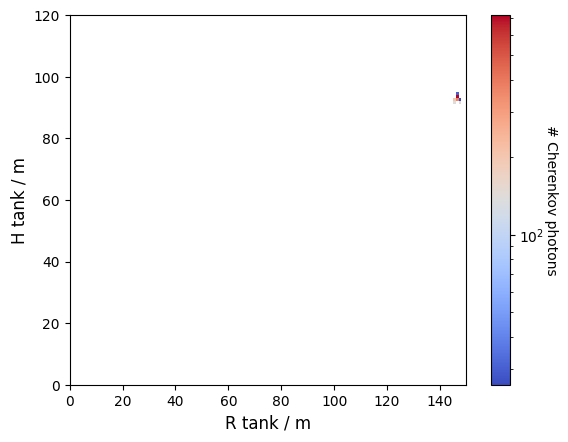

In [46]:
hist2d = plt.hist2d(all_photons_r, all_photons_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(vmin=np.min(hist2d[0])), cmap = plt.cm.coolwarm)
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], cmap = plt.cm.coolwarm)

plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Cherenkov photons', rotation=270, labelpad=10)

(120, 150)
(120, 150)


Text(0, 0.5, 'H tank / m')

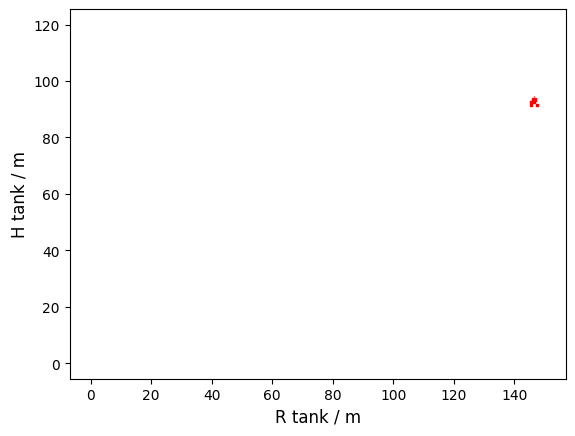

In [47]:
plt.figure(dpi=100)
bin_count = hist2d[0]
ph_density = bin_count / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)